# Weather Data Preprocessing

#### TODO: report types handling, handle the rest of compound fields (look at https://www.airppm.org/for-participants/training-sets), outliers handling
#### TODO: final goal -> combine the weather files with the air quality measurements to start training a model

## Imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

## Merge Weather Files
- merge all the available weather files
- get rid of irrelevant columns

In [2]:
weather_dir = Path("../data/raw/Weather_Krakow")

weather_files = sorted(weather_dir.glob("*.csv"))

dfs = []

for f in weather_files:
    df = pd.read_csv(f, dtype=str)
    dfs.append(df)
    
# Normalize column names
dfs = [df.rename(columns=lambda x: x.strip()) for df in dfs]
df = pd.concat(dfs, ignore_index=True, sort=False)

# drop station related or constant columns
df = df.drop(columns=[
    "STATION", # only 1 station
    "SOURCE", # always 4
    "CALL_SIGN", # always 99999
    "QUALITY_CONTROL", # always V020
    "NAME", #always BALICE, PL
    "ED1", #either missing or 25,U,9999,9
    "LATITUDE", "LONGITUDE", "ELEVATION",
    "REM", #random codes
    "GF1", #too complex preprocessing without the columns properties description
    "GE1" #missing data
    
])

print(df.shape)
print(df.columns)
df.to_csv("../data/processed/weather_all_years.csv", index=False)

(130328, 32)
Index(['DATE', 'REPORT_TYPE', 'WND', 'CIG', 'VIS', 'TMP', 'DEW', 'SLP', 'AA1',
       'AA2', 'AJ1', 'AY1', 'AY2', 'AZ1', 'AZ2', 'GA1', 'GA2', 'GA3', 'IA1',
       'KA1', 'KA2', 'MA1', 'MD1', 'MW1', 'MW2', 'MW3', 'OC1', 'OD1', 'OD2',
       'OD3', 'EQD', 'IA2'],
      dtype='object')


In [3]:
df = pd.read_csv("../data/processed/weather_all_years.csv", dtype=str)

## Drop columns with >80% missing values

In [4]:
# assuming your DataFrame is called df
missing_percent = df.isna().mean() * 100  # % of missing per column
cols_high_missing = missing_percent[missing_percent > 80].index.tolist()

print("Columns with >80% missing values:")
print(cols_high_missing)

df = df.drop(columns=cols_high_missing)

Columns with >80% missing values:
['AA1', 'AA2', 'AJ1', 'AY1', 'AY2', 'AZ1', 'AZ2', 'GA3', 'IA1', 'KA1', 'KA2', 'MW2', 'MW3', 'OC1', 'OD1', 'OD2', 'OD3', 'EQD', 'IA2']


## Split Compound Columns

### Wind
1. split the WND column into direction, dir_quality, type, speed and speed_quality
2. handle placeholders like 999 or 9999
3. handle the wind type meanings
4. keep only the measurements with reliable quality (1)
5. encode the wind direction as sin/cos (cyclic encoding)
6. keep the wind direction and wind speed in the final dataframe

In [5]:
# --- Split WND into parts ---
wnd_parts = df["WND"].fillna("").str.split(",", expand=True)

df["wind_dir_deg"] = pd.to_numeric(wnd_parts[0], errors="coerce")
df["wind_dir_qc"] = wnd_parts[1]
df["wind_type"]   = wnd_parts[2]
df["wind_speed_raw"] = pd.to_numeric(wnd_parts[3], errors="coerce")
df["wind_speed_qc"] = wnd_parts[4]

# --- Handle placeholder values ---
df.loc[df["wind_dir_deg"] == 999, "wind_dir_deg"] = np.nan
df.loc[df["wind_speed_raw"] == 9999, "wind_speed_raw"] = np.nan

# --- Handle wind_type meanings ---
df.loc[df["wind_type"] == "C", "wind_speed_raw"] = 0
df.loc[df["wind_type"].isin(["C","V"]), "wind_dir_deg"] = np.nan

# --- Keep only reliable measurements ---
df.loc[df["wind_dir_qc"] != "1", "wind_dir_deg"] = np.nan
df.loc[df["wind_speed_qc"] != "1", "wind_speed_raw"] = np.nan

# Cyclic encoding of wind direction
df["wind_dir_sin"] = np.sin(np.radians(df["wind_dir_deg"]))
df["wind_dir_cos"] = np.cos(np.radians(df["wind_dir_deg"]))

# --- Drop original WND column and helper columns ---
df = df.drop(columns=["WND", "wind_dir_qc", "wind_type", "wind_speed_qc", "wind_dir_deg"])

# Optional: check result
print(df.head())
print(df[["wind_speed_raw", "wind_dir_sin", "wind_dir_cos"]].describe())

                  DATE REPORT_TYPE          CIG           VIS      TMP  \
0  2019-01-01T00:00:00       FM-12  99999,9,9,N  006000,1,9,9  +0001,1   
1  2019-01-01T00:00:00       FM-15  00884,1,9,N  006000,1,9,9  +0000,1   
2  2019-01-01T00:30:00       FM-15  00610,1,C,N  006000,1,9,9  +0000,1   
3  2019-01-01T01:00:00       FM-12  99999,9,9,N  006000,1,9,9  +0008,1   
4  2019-01-01T01:00:00       FM-15  00610,1,C,N  006000,1,9,9  +0010,1   

       DEW      SLP                 GA1                 GA2              MA1  \
0  -0009,1  10302,1  07,1,+00800,1,06,1                 NaN  99999,9,09996,1   
1  -0010,1  99999,9  02,1,+00640,1,99,9  07,1,+00884,1,99,9  10280,1,99999,9   
2  -0010,1  99999,9  07,1,+00610,1,99,9                 NaN  10280,1,99999,9   
3  -0008,1  10299,1  07,1,+00800,1,06,1                 NaN  99999,9,09994,1   
4  -0010,1  99999,9  07,1,+00610,1,99,9                 NaN  10280,1,99999,9   

                MD1   MW1  wind_speed_raw  wind_dir_sin  wind_dir_cos  
0 

### Cloud Ceiling
1. split CIG into ceiling height, method, quality and coverage
2. convert coverage from N/Y to 0/1 
3. handle placeholder height values
4. keep only the height where method and quality were valid
5. keep the ceiling_height and ceiling_coverage in the final dataFrame

In [6]:
cig_parts = df["CIG"].fillna("").str.split(",", expand=True)

# Extract raw columns
df["ceiling_height_ft"] = pd.to_numeric(cig_parts[0], errors="coerce")
df["ceiling_method"] = cig_parts[1].replace("9", np.nan)  # only 9 → NaN
df["ceiling_quality"] = cig_parts[2].replace("9", np.nan) # only 9 → NaN
df["ceiling_coverage"] = cig_parts[3].map({"N": 0, "Y": 1, "9": np.nan})

# Handle placeholder height values
df.loc[df["ceiling_height_ft"] == 99999, "ceiling_height_ft"] = np.nan

# Keep only reliable height and coverage (non-NaN method/quality)
df.loc[df["ceiling_method"].isna() | df["ceiling_quality"].isna(), "ceiling_height_ft"] = np.nan

# Drop helper columns

df = df.drop(columns=["ceiling_method", "ceiling_quality", "CIG"])

df[["ceiling_height_ft", "ceiling_coverage"]].describe()


,ceiling_height_ft,ceiling_coverage
count,28654.000000,129317.000000
mean,748.836463,0.222067
std,620.591988,0.415637
min,0.000000,0.000000
25%,210.000000,0.000000
50%,549.000000,0.000000
75%,1219.000000,0.000000
max,10500.000000,1.000000


### Visibility
1. split the compound field
2. keep the visibility in meters only if the 2nd value is 1
3. TODO: FIGURE OUT WHERE TO CUT THE VISIBILITY CUZ 70KM IS QUITE UNREALISTIC

In [7]:
# Split the VIS column into parts
vis_parts = df["VIS"].fillna("").str.split(",", expand=True)

# Assign columns
df["visibility_m"] = pd.to_numeric(vis_parts[0], errors="coerce")      # meters
df["visibility_var"] = vis_parts[1]                                   # variability
df["visibility_quality"] = vis_parts[2]                                # quality
df["visibility_extra"] = vis_parts[3]                                  # unknown, can drop later

# Replace placeholder/missing values
df.loc[df["visibility_m"] == 99999, "visibility_m"] = np.nan
df.loc[df["visibility_m"] == 9999, "visibility_m"] = np.nan
df.loc[df["visibility_var"] != "1", "visibility_m"] = np.nan

# Display stats for all visibility columns
visibility_cols = ["visibility_m", "visibility_var", "visibility_quality", "visibility_extra"]
print(df[visibility_cols].describe(include="all"))

df = df.drop(columns=["visibility_var", "visibility_quality", "visibility_extra", "VIS"])


        visibility_m visibility_var visibility_quality visibility_extra
count   65451.000000         130328             130328           130328
unique           NaN              2                  1                1
top              NaN              1                  9                9
freq             NaN         103242             130328           130328
mean    18424.588685            NaN                NaN              NaN
std     16529.051113            NaN                NaN              NaN
min         0.000000            NaN                NaN              NaN
25%      5000.000000            NaN                NaN              NaN
50%     10000.000000            NaN                NaN              NaN
75%     30000.000000            NaN                NaN              NaN
max     70001.000000            NaN                NaN              NaN


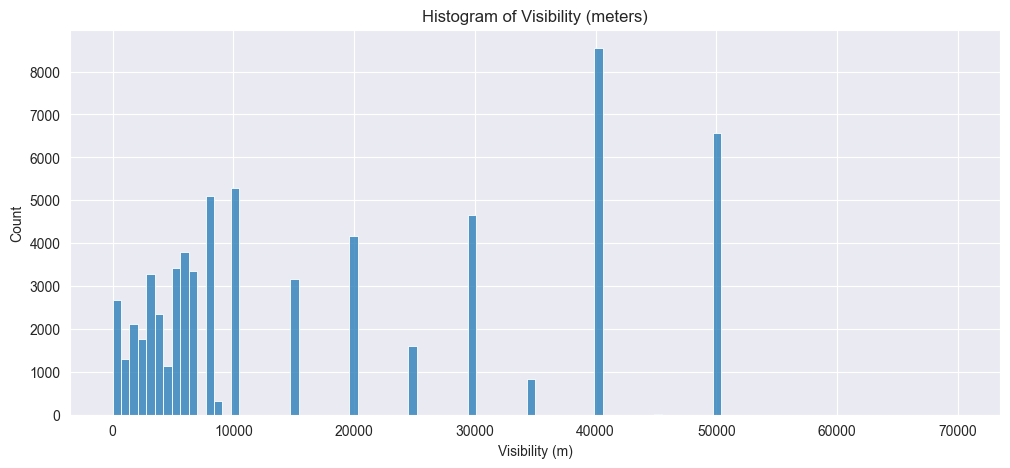

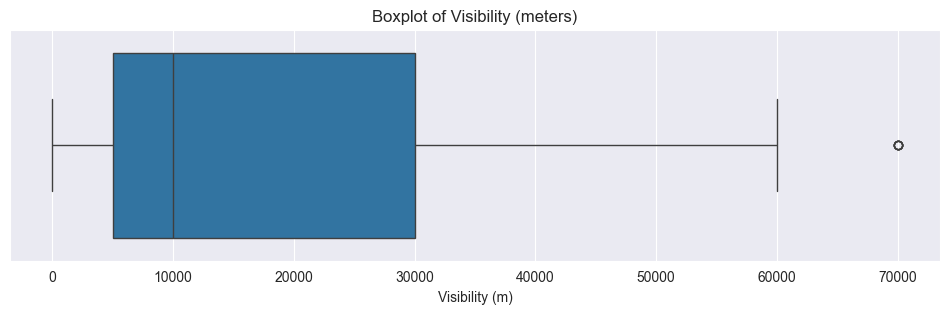

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Remove NaN values for plotting
vis_data = df["visibility_m"].dropna()

# Histogram
plt.figure(figsize=(12,5))
sns.histplot(vis_data, bins=100, kde=False)
plt.title("Histogram of Visibility (meters)")
plt.xlabel("Visibility (m)")
plt.ylabel("Count")
plt.show()

# Boxplot (good for spotting outliers)
plt.figure(figsize=(12,3))
sns.boxplot(x=vis_data)
plt.title("Boxplot of Visibility (meters)")
plt.xlabel("Visibility (m)")
plt.show()

### Temperature, DEW, SLP
1. Split the compound field
2. keep the measurement only if the quality is 1

In [9]:
# Split TMP into temperature and quality
tmp_parts = df["TMP"].fillna("").str.split(",", expand=True)

# Convert temperature to numeric (values are °C * 10)
df["temperature_C"] = pd.to_numeric(tmp_parts[0], errors="coerce") / 10.0
df["temperature_qlt"] = pd.to_numeric(tmp_parts[1], errors="coerce")

df.loc[df["temperature_qlt"] != 1, "temperature_C"] = np.nan

# Optional: drop the original TMP column
df.drop(columns=["TMP", "temperature_qlt"], inplace=True)

# Inspect
print(df["temperature_C"].describe())


count    130293.000000
mean          9.937908
std           8.582025
min         -14.000000
25%           3.000000
50%           9.400000
75%          16.700000
max          35.400000
Name: temperature_C, dtype: float64


In [10]:
# Split TMP into temperature and quality
slp_parts = df["SLP"].fillna("").str.split(",", expand=True)

# Convert temperature to numeric (values are °C * 10)
df["SLP_hpa"] = pd.to_numeric(slp_parts[0], errors="coerce") / 10.0
df["SLP_qlt"] = pd.to_numeric(slp_parts[1], errors="coerce")

df.loc[df["SLP_qlt"] != 1, "SLP_hpa"] = np.nan

# Optional: drop the original TMP column
df.drop(columns=["SLP", "SLP_qlt"], inplace=True)

# Inspect
print(df["SLP_hpa"].describe())


count    43396.000000
mean      1017.115112
std          8.686429
min        985.400000
25%       1011.800000
50%       1017.200000
75%       1022.600000
max       1047.100000
Name: SLP_hpa, dtype: float64


In [11]:
# Split TMP into temperature and quality
dew_parts = df["DEW"].fillna("").str.split(",", expand=True)

# Convert temperature to numeric (values are °C * 10)
df["DEW_C"] = pd.to_numeric(dew_parts[0], errors="coerce") / 10.0
df["DEW_qlt"] = pd.to_numeric(dew_parts[1], errors="coerce")

df.loc[df["DEW_qlt"] != 1, "DEW_C"] = np.nan

# Optional: drop the original TMP column
df.drop(columns=["DEW", "DEW_qlt"], inplace=True)

# Inspect
print(df["DEW_C"].describe())


count    130309.000000
mean          5.442331
std           7.307677
min         -18.000000
25%           0.000000
50%           5.000000
75%          11.400000
max          23.000000
Name: DEW_C, dtype: float64


## Save to csv after basic preprocessing

In [12]:
df.to_csv("../data/processed/weather_basic_preprocessing.csv", index=False)

## Additional Compound fields preprocessing

In [13]:
df = pd.read_csv("../data/processed/weather_basic_preprocessing.csv")

In [14]:
# % of missing values per column
missing_percent = df.isna().mean() * 100
print(missing_percent.sort_values(ascending=False))

ceiling_height_ft    78.013934
GA2                  74.032441
MW1                  72.427260
SLP_hpa              66.702474
MD1                  66.660273
visibility_m         49.779786
GA1                  30.107882
wind_dir_sin         29.543920
wind_dir_cos         29.543920
wind_speed_raw        3.614726
ceiling_coverage      0.775735
temperature_C         0.026855
DEW_C                 0.014579
MA1                   0.000767
REPORT_TYPE           0.000000
DATE                  0.000000
dtype: float64


### MA1 - most likely precipation related
1. Split the compound field
2. Keep only the numeric values, where the quality of the measurement was "1"

In [15]:
# Split MA1 into 4 subcolumns
df[['MA1_main', 'MA1_q1', 'MA1_sec', 'MA1_q2']] = df['MA1'].str.split(',', expand=True)

# Convert numeric columns
df['MA1_main'] = pd.to_numeric(df['MA1_main'], errors='coerce')
df['MA1_sec']  = pd.to_numeric(df['MA1_sec'], errors='coerce')

# Replace error code 99999 with NaN
df['MA1_main'] = df['MA1_main'].replace(99999, np.nan)
df['MA1_sec']  = df['MA1_sec'].replace(99999, np.nan)

#Keep only the reliable meassures
df.loc[df["MA1_q1"] != "1", 'MA1_main'] = np.nan
df.loc[df["MA1_q2"] != "1", 'MA1_sec'] = np.nan

# Scale values if needed (divide by 10 or 100 depending on docs) – here by 10:
df['MA1_main'] = df['MA1_main']
df['MA1_sec']  = df['MA1_sec']

# Keep only the measures (drop quality flags)
df = df.drop(columns=['MA1', 'MA1_q1', 'MA1_q2'])
df[["MA1_main", "MA1_sec"]].describe()

,MA1_main,MA1_sec
count,86818.000000,43425.000000
mean,10158.602018,9878.963984
std,85.373786,83.376204
min,9840.000000,9566.000000
25%,10110.000000,9830.000000
50%,10160.000000,9882.000000
75%,10210.000000,9932.000000
max,10450.000000,10162.000000


### GA1, GA2 - cloud amount/height/type triplets
1. Split the compound column
2. Keep only reliable measures

In [16]:
# Split into 6 subcolumns
df[['GA1_amt', 'GA1_q1', 'GA1_height', 'GA1_q2', 'GA1_type', 'GA1_q3']] = df['GA1'].str.split(',', expand=True)

# Convert to numeric
df['GA1_amt']    = pd.to_numeric(df['GA1_amt'], errors='coerce')
df['GA1_height'] = pd.to_numeric(df['GA1_height'], errors='coerce')
df['GA1_type']   = pd.to_numeric(df['GA1_type'], errors='coerce')

# Handle missing codes (99 for amount/type, 99999 for height)
df['GA1_amt']    = df['GA1_amt'].replace(99, np.nan)
df['GA1_height'] = df['GA1_height'].replace(99999, np.nan)
df['GA1_type']   = df['GA1_type'].replace(99, np.nan)

# Keep only reliable measures
df.loc[df["GA1_q1"] != "1", 'GA1_amt'] = np.nan
df.loc[df["GA1_q2"] != "1", 'GA1_height'] = np.nan
df.loc[df["GA1_q3"] != "1", 'GA1_type'] = np.nan

# Drop original + quality flags
df = df.drop(columns=['GA1', 'GA1_q1', 'GA1_q2', 'GA1_q3'])
df[["GA1_amt", "GA1_height", "GA1_type"]].describe()

,GA1_amt,GA1_height,GA1_type
count,86015.000000,79980.000000,42535.000000
mean,4.439877,906.736459,5.710779
std,2.458971,616.949302,2.621757
min,0.000000,0.000000,0.000000
25%,2.000000,335.000000,3.000000
50%,4.000000,800.000000,6.000000
75%,7.000000,1372.000000,8.000000
max,9.000000,10500.000000,10.000000


In [17]:
# Split GA2 into 6 subcolumns
df[['GA2_amt', 'GA2_q1', 'GA2_height', 'GA2_q2', 'GA2_type', 'GA2_q3']] = df['GA2'].str.split(',', expand=True)

# Convert to numeric
df['GA2_amt']    = pd.to_numeric(df['GA2_amt'], errors='coerce')
df['GA2_height'] = pd.to_numeric(df['GA2_height'], errors='coerce')
df['GA2_type']   = pd.to_numeric(df['GA2_type'], errors='coerce')

# Handle missing codes (99 for amount/type, 99999 for height)
df['GA2_amt']    = df['GA2_amt'].replace(99, np.nan)
df['GA2_height'] = df['GA2_height'].replace(99999, np.nan)
df['GA2_type']   = df['GA2_type'].replace(99, np.nan)

# Keep only reliable measures (quality flags == "1")
df.loc[df["GA2_q1"] != "1", 'GA2_amt']    = np.nan
df.loc[df["GA2_q2"] != "1", 'GA2_height'] = np.nan
df.loc[df["GA2_q3"] != "1", 'GA2_type']   = np.nan

# Drop original + quality flags
df = df.drop(columns=['GA2', 'GA2_q1', 'GA2_q2', 'GA2_q3'])

# Quick check
df[["GA2_amt", "GA2_height", "GA2_type"]].describe()

,GA2_amt,GA2_height,GA2_type
count,20745.000000,20747.000000,15211.000000
mean,6.516317,952.475008,2.806259
std,1.351870,566.055312,2.530550
min,1.000000,0.000000,0.000000
25%,7.000000,427.000000,0.000000
50%,7.000000,914.000000,3.000000
75%,7.000000,1524.000000,3.000000
max,8.000000,2438.000000,10.000000


### MD1

In [18]:
# Split MD1 into 6 subcolumns
df[['MD1_m1', 'MD1_q1', 'MD1_m2', 'MD1_q2', 'MD1_m3', 'MD1_q3']] = df['MD1'].str.split(',', expand=True)

# Convert measures to numeric
df['MD1_m1'] = pd.to_numeric(df['MD1_m1'], errors='coerce')
df['MD1_m2'] = pd.to_numeric(df['MD1_m2'], errors='coerce')
df['MD1_m3'] = pd.to_numeric(df['MD1_m3'], errors='coerce')

# Replace placeholder codes (+999) with NaN
df['MD1_m1'] = df['MD1_m1'].replace(999, np.nan)
df['MD1_m2'] = df['MD1_m2'].replace(999, np.nan)
df['MD1_m3'] = df['MD1_m3'].replace(999, np.nan)

# Keep only reliable measures where quality flag == "1"
df.loc[df['MD1_q1'] != '1', 'MD1_m1'] = np.nan
df.loc[df['MD1_q2'] != '1', 'MD1_m2'] = np.nan
df.loc[df['MD1_q3'] != '1', 'MD1_m3'] = np.nan

# Drop original + quality flags
df = df.drop(columns=['MD1', 'MD1_q1', 'MD1_q2', 'MD1_q3'])
df = df.drop(columns=["MD1_m3"]) # always NaN

# Check results
print(df[['MD1_m1', 'MD1_m2']].describe())

             MD1_m1        MD1_m2
count  40986.000000  43450.000000
mean       4.634363      8.498803
std        2.514957      7.548675
min        0.000000      0.000000
25%        2.000000      3.000000
50%        5.000000      7.000000
75%        7.000000     12.000000
max        8.000000    103.000000


### MW1


In [19]:
# Split MW1 into measure + quality
df[['MW1_val', 'MW1_q']] = df['MW1'].str.split(',', expand=True)

# Convert measure to numeric
df['MW1_val'] = pd.to_numeric(df['MW1_val'], errors='coerce')

# Replace placeholder (if any, e.g., 99/99999) with NaN
df['MW1_val'] = df['MW1_val'].replace([99, 999, 9999, 99999], np.nan)

# Keep only reliable values where quality == "1"
df.loc[df['MW1_q'] != '1', 'MW1_val'] = np.nan

# Drop original + quality flag
df = df.drop(columns=['MW1', 'MW1_q'])

# Check results
print(df['MW1_val'].describe())

count    35920.000000
mean        33.811693
std         27.487458
min          0.000000
25%         10.000000
50%         20.000000
75%         61.000000
max         98.000000
Name: MW1_val, dtype: float64


In [20]:
df.describe()

,wind_speed_raw,wind_dir_sin,wind_dir_cos,ceiling_height_ft,ceiling_coverage,visibility_m,temperature_C,SLP_hpa,DEW_C,MA1_main,MA1_sec,GA1_amt,GA1_height,GA1_type,GA2_amt,GA2_height,GA2_type,MD1_m1,MD1_m2,MW1_val
count,125617.000000,91824.000000,91824.000000,28654.000000,129317.000000,65451.000000,130293.000000,43396.000000,130309.000000,86818.000000,43425.000000,86015.000000,79980.000000,42535.000000,20745.000000,20747.000000,15211.000000,40986.000000,43450.000000,35920.000000
mean,31.560330,-0.213823,-0.016201,748.836463,0.222067,18424.588685,9.937908,1017.115112,5.442331,10158.602018,9878.963984,4.439877,906.736459,5.710779,6.516317,952.475008,2.806259,4.634363,8.498803,33.811693
std,21.531019,0.721866,0.657980,620.591988,0.415637,16529.051113,8.582025,8.686429,7.307677,85.373786,83.376204,2.458971,616.949302,2.621757,1.351870,566.055312,2.530550,2.514957,7.548675,27.487458
min,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,-14.000000,985.400000,-18.000000,9840.000000,9566.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,-0.866025,-0.642788,210.000000,0.000000,5000.000000,3.000000,1011.800000,0.000000,10110.000000,9830.000000,2.000000,335.000000,3.000000,7.000000,427.000000,0.000000,2.000000,3.000000,10.000000
50%,26.000000,-0.500000,-0.173648,549.000000,0.000000,10000.000000,9.400000,1017.200000,5.000000,10160.000000,9882.000000,4.000000,800.000000,6.000000,7.000000,914.000000,3.000000,5.000000,7.000000,20.000000
75%,41.000000,0.642788,0.642788,1219.000000,0.000000,30000.000000,16.700000,1022.600000,11.400000,10210.000000,9932.000000,7.000000,1372.000000,8.000000,7.000000,1524.000000,3.000000,7.000000,12.000000,61.000000
max,216.000000,1.000000,1.000000,10500.000000,1.000000,70001.000000,35.400000,1047.100000,23.000000,10450.000000,10162.000000,9.000000,10500.000000,10.000000,8.000000,2438.000000,10.000000,8.000000,103.000000,98.000000


In [23]:
df.head(10)

,DATE,REPORT_TYPE,wind_speed_raw,wind_dir_sin,wind_dir_cos,ceiling_height_ft,ceiling_coverage,visibility_m,temperature_C,SLP_hpa,...,MA1_sec,GA1_amt,GA1_height,GA1_type,GA2_amt,GA2_height,GA2_type,MD1_m1,MD1_m2,MW1_val
0,2019-01-01T00:00:00,FM-12,30.0,-0.866025,-0.500000,NaN,0.0,6000.0,0.1,1030.2,...,9996.0,7.0,800.0,6.0,NaN,NaN,NaN,8.0,11.0,10.0
1,2019-01-01T00:00:00,FM-15,26.0,-0.866025,-0.500000,NaN,0.0,6000.0,0.0,NaN,...,NaN,2.0,640.0,NaN,7.0,884.0,NaN,NaN,NaN,NaN
2,2019-01-01T00:30:00,FM-15,26.0,-0.766044,-0.642788,610.0,0.0,6000.0,0.0,NaN,...,NaN,7.0,610.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01T01:00:00,FM-12,30.0,-0.642788,-0.766044,NaN,0.0,6000.0,0.8,1029.9,...,9994.0,7.0,800.0,6.0,NaN,NaN,NaN,7.0,11.0,10.0
4,2019-01-01T01:00:00,FM-15,31.0,-0.642788,-0.766044,610.0,0.0,6000.0,1.0,NaN,...,NaN,7.0,610.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-01-01T01:30:00,FM-15,36.0,-0.642788,-0.766044,671.0,0.0,6000.0,1.0,NaN,...,NaN,7.0,671.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2019-01-01T02:00:00,FM-12,40.0,-0.500000,-0.866025,NaN,0.0,6000.0,0.8,1028.6,...,9981.0,3.0,800.0,6.0,NaN,NaN,2.0,8.0,21.0,10.0
7,2019-01-01T02:00:00,FM-15,31.0,-0.642788,-0.766044,701.0,0.0,6000.0,1.0,NaN,...,NaN,7.0,701.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2019-01-01T02:30:00,FM-15,26.0,-0.642788,-0.766044,NaN,0.0,5000.0,0.0,NaN,...,NaN,2.0,701.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0
9,2019-01-01T03:00:00,FM-12,30.0,-0.642788,-0.766044,NaN,0.0,5000.0,-0.8,1027.3,...,9967.0,NaN,NaN,2.0,NaN,NaN,NaN,8.0,29.0,10.0


In [22]:
# % of missing values per column
missing_percent = df.isna().mean() * 100
print(missing_percent.sort_values(ascending=False))

GA2_type             88.328678
GA2_amt              84.082469
GA2_height           84.080934
ceiling_height_ft    78.013934
MW1_val              72.438770
MD1_m1               68.551654
GA1_type             67.363115
SLP_hpa              66.702474
MA1_sec              66.680222
MD1_m2               66.661040
visibility_m         49.779786
GA1_height           38.631760
GA1_amt              34.001136
MA1_main             33.384998
wind_dir_sin         29.543920
wind_dir_cos         29.543920
wind_speed_raw        3.614726
ceiling_coverage      0.775735
temperature_C         0.026855
DEW_C                 0.014579
DATE                  0.000000
REPORT_TYPE           0.000000
dtype: float64


# Save after weather preprocessing 

In [25]:
df.to_csv("../data/processed/weather_pre_algorithm.csv", index=False)